In [1]:
import json 
import numpy as np 
import pandas as pd 
from textblob import TextBlob
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import os 
from glob import glob 
import re
import preprocessor as tp
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osmanmamun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osmanmamun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
tanishq_files = glob(r'../data/raw/*anishq*.json')

tweets = []
for file in tanishq_files:
    print(f'Processing file: {file}')
    with open(file, encoding='utf-8') as f:
        temp = json.load(f)
        tweets.extend([tweet['full_text'] for tweet in temp if tweet['full_text'].isascii()])

print(f'Number of tweets extracted: {len(tweets)}')

tanishq_data = pd.DataFrame(tweets, columns=['Tweet'])

del tweets

Processing file: ../data/raw/ekatvambytanishq.json
Processing file: ../data/raw/BoycottTanishqJewelry.json
Processing file: ../data/raw/boycott_tanishq.json
Processing file: ../data/raw/BoycottTanishq2.json
Processing file: ../data/raw/BoycottTanishq.json
Number of tweets extracted: 9427


In [3]:
#tanishq_data['Hashtag'] = tanishq_data['Tweet'].apply(lambda x: re.findall(r'#(\w+)', x))
tanishq_data['Tweet'] = tanishq_data['Tweet'].apply(lambda x: re.sub(r'#(\w+)', r'\1', x))

In [4]:
# Removal of @mentions, RT's, HTTPs etc. 
tp.set_options(tp.OPT.URL, tp.OPT.EMOJI, tp.OPT.MENTION, tp.OPT.NUMBER) 
tanishq_data['Clean Tweet'] = tanishq_data['Tweet'].apply(tp.clean)

In [6]:
tanishq_data['Clean Tweet'] = tanishq_data['Clean Tweet'].str.lower()
tanishq_data['Clean Tweet'] = tanishq_data['Clean Tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', (x)))

In [7]:
from ekphrasis.classes.segmenter import Segmenter
seg = Segmenter(corpus="Twitter") 

tanishq_data["Clean Tweet Segmented"] = tanishq_data["Clean Tweet"].apply(lambda x: [seg.segment(i) for i in x.split()])

Reading Twitter - 1grams ...
Reading Twitter - 2grams ...


In [10]:
# Tokenization, Stemming, removing stop words etc. 
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
stop_words = set(stopwords.words('english'))
tanishq_data['Clean Tweet'] = tanishq_data.apply(lambda x: ' '.join(x['Clean Tweet Segmented']), axis=1)
tanishq_data['Tokenized Tweet'] = tanishq_data['Clean Tweet'].apply(
    lambda x: [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize(x) if w not in stop_words])
tanishq_data['Clean Tokenized Tweet'] = tanishq_data['Tokenized Tweet'].apply(lambda x: ' '.join(set(x)))

In [24]:
tanishq_data[tanishq_data['Clean Tokenized Tweet'].str.contains("tanishqboycott")]

,Tweet,Clean Tweet,Clean Tweet Segmented,Tokenized Tweet,Clean Tokenized Tweet,Subjectivity,Polarity,Sentiment


In [11]:
# Subjectivity and Polarity of the tweets
tanishq_data['Subjectivity'] = tanishq_data['Clean Tokenized Tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
tanishq_data['Polarity'] = tanishq_data['Clean Tokenized Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
tanishq_data['Sentiment'] = tanishq_data['Polarity'].apply(lambda x: "Positive" if x > 0 else "negative" if x < 0 else "Neutral")

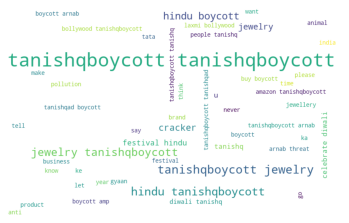

In [25]:
# Plot word cloud
words = "".join(tanishq_data["Clean Tokenized Tweet"])
wordcloud = WordCloud(height=500, width=800, max_font_size=200, max_words=50, background_color="white").generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
tanishq_data

,Tweet,Hashtag,Clean Tweet,Hashtag Segmented,Tokenized Tweet,Subjectivity,Polarity,Sentiment
0,I hv been disappointed by the fact that Tanish...,"[EkatvamByTanishq, supporttanishq]",i hv been disappointed by the fact that tanish...,"[ekatvam by tanishq, support tanishq]","[hv, disappointed, fact, tanishq, pull, ad, be...",0.875000,-0.187500,negative
1,@TanishqJewelry @RNTata2000 #EkatvamByTanishq...,"[EkatvamByTanishq, HappyDiwali2020]",thank you so much for beautiful gift we stand...,"[ekatvam by tanishq, happy diwali 2020]","[thank, much, beautiful, gift, stand, united, ...",0.733333,0.616667,Positive
2,#EkatvamByTanishq @tanishq #HappyDiwali @sayan...,"[EkatvamByTanishq, HappyDiwali]",a wonderful ad and you all look simply gorgeou...,"[ekatvam by tanishq, happy diwali]","[wonderful, ad, look, simply, gorgeous, adekat...",0.966667,0.833333,Positive
3,Hope @TanishqJewelry wishes d same on #NewYear...,"[NewYearsEve, Hindus, ThisDiwali_BoycottTanish...",hope wishes d same on have u ever greeted any1...,"[new years eve, hindus, this diwali _ boycott ...","[hope, wish, u, ever, greeted, 1, lyk, except,...",0.125000,0.000000,Neutral
4,@Ramesh_hjs @RituRathaur @HinduJagrutiOrg @rah...,"[TanishqEkatvam, EkatvamByTanishq, ThisDiwali_...",this is called by ms r united n hindus r divid...,"[tanishq ekatvam, ekatvam by tanishq, this diw...","[called, m, r, united, n, hindu, r, divided, t...",0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...
9422,@TanishqJewelry @AlayaF___ @NimratOfficial @Ne...,[boycotttanishq],boycott tanishq,[boycott tanishq],"[boycott, tanishq]",0.000000,0.000000,Neutral
9423,Why every time same mistake #boycotttanishq,[boycotttanishq],why every time same mistakeboycott tanishq,[boycott tanishq],"[every, time, mistakeboycott, tanishq]",0.125000,0.000000,Neutral
9424,#boycotttanishq stop giving gyaan to us... Sto...,[boycotttanishq],stop giving gyaan to us stop killing animals o...,[boycott tanishq],"[stop, giving, gyaan, u, stop, killing, animal...",0.000000,0.000000,Neutral
9425,"So Diwali is only buying gold, ""nice"" clothes,...",[boycotttanishq],so diwali is only buying gold nice clothes par...,[boycott tanishq],"[diwali, buying, gold, nice, clothes, party, a...",0.900000,0.075000,Positive


In [12]:
pd.set_option('display.width', 1000)
tanishq_data[['Tweet', 'Polarity']].sort_values(by='Polarity').head(10).style.background_gradient()

,Tweet,Polarity
4408,"#boycotttanishq we do , worst brand in the world",-1.000000
6582,"@sayanigupta ""Axone"" me meat banana culture and tradition h, par Diwali me firecrackers nahi. #boycotttanishq #Hypocrite Killing animals in the name of religion is disgusting too.",-1.000000
1594,"@sayanigupta ""Axone"" me meat banana culture and tradition h, par Diwali me firecrackers nahi. #boycotttanishq #Hypocrite Killing animals in the name of religion is disgusting too.",-1.000000
4367,@TanishqJewelry @AlayaF___ @NimratOfficial @Neenagupta001 @sayanigupta This deewali let's unite and #boycotttanishq and punish them for insulting our festival.,-1.000000
9355,@TanishqJewelry @AlayaF___ @NimratOfficial @Neenagupta001 @sayanigupta This deewali let's unite and #boycotttanishq and punish them for insulting our festival.,-1.000000
9396,"#boycotttanishq we do , worst brand in the world",-1.000000
5355,"Being an ex Tata Tanishq employee, I feel disgusted... Stop teaching us how to celebrate our festivals #boycotttanishq @TanishqJewelry https://t.co/oktsZj1ss4",-1.000000
5047,@kshtriy_maratha @_PreetiPandey @mamta_kale @anujakapurindia @TanishqJewelry Tq abhi toh tera pradhushan nikala tha tu fir bola 4 us Hindu it is celebration of victory over evil #boycotttanishq Btw i havnt brought any nonsense in my life fm Tanishq V buy our gold from Sonar kaka Whn he pack our gold thy put puja ka phool in our gold #NationStands4Arnab,-1.000000
2364,"But of course this picture is trending during Diwali ""saying dont give gyan on how to celebrate Diwali"". Those fighting for their rights to in the country being compared to idiots believing in fiction. Waah @narendramodi you have brought out the worst in people #boycotttanishq https://t.co/S0SMIuMJsS",-0.900000
7352,"But of course this picture is trending during Diwali ""saying dont give gyan on how to celebrate Diwali"". Those fighting for their rights to in the country being compared to idiots believing in fiction. Waah @narendramodi you have brought out the worst in people #boycotttanishq https://t.co/S0SMIuMJsS",-0.900000


In [13]:
tanishq_data[['Tweet', 'Polarity']].sort_values(by='Polarity', ascending=False).head(10).style.background_gradient()

,Tweet,Polarity
3348,@satyasunaam1 @SwarajyaMag Best thing to do is #boycotttanishq,1.000000
7652,Best Hair Loss Treatment in Delhi - Immer Organic https://t.co/EtMbglDqZI #hairfall #hairfallsolution #hairloss #hairlosstreatment #ReasonsOfHairFall #HairLossTreatmentinDelhi #HairFallTreatmentinDelhi #Adipurush #JusticeForAishwarya #boycotttanishq,1.000000
8336,@satyasunaam1 @SwarajyaMag Best thing to do is #boycotttanishq,1.000000
5084,#boycotttanishq again!!! Bhai @TanishqJewelry wish you a very happy DHANTERAS in advance!!,1.000000
8768,Keep at it moroons with your two-bit wisdom on Hinduism. Your #boycotttanishq rants will have zero effect on people like myself who finds #tanishqisbest,1.000000
2664,Best Hair Loss Treatment in Delhi - Immer Organic https://t.co/EtMbglDqZI #hairfall #hairfallsolution #hairloss #hairlosstreatment #ReasonsOfHairFall #HairLossTreatmentinDelhi #HairFallTreatmentinDelhi #Adipurush #JusticeForAishwarya #boycotttanishq,1.000000
8452,#boycotttanishq. This company should learn advisertising from Cadbury..the best Diwali ad seen for Diwali,1.000000
7188,"As per Tanishq , Gold electroplating and Gold extraction process releases oxygen in atmosphere. They are very proud to use Alu-sona machine invented by Rahul Gandhi. #boycotttanishq",1.000000
3464,#boycotttanishq. This company should learn advisertising from Cadbury..the best Diwali ad seen for Diwali,1.000000
2200,"As per Tanishq , Gold electroplating and Gold extraction process releases oxygen in atmosphere. They are very proud to use Alu-sona machine invented by Rahul Gandhi. #boycotttanishq",1.000000


In [14]:
tanishq_data["Sentiment"].value_counts()

Neutral     7012
Positive    1518
negative     897
Name: Sentiment, dtype: int64

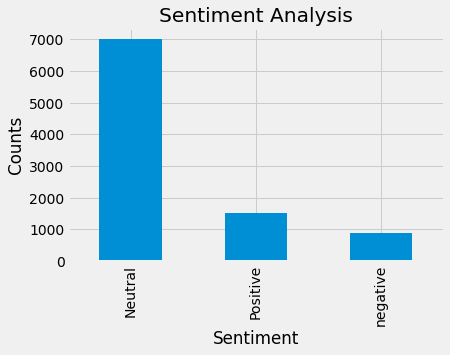

In [15]:
plt.style.use("fivethirtyeight")
tanishq_data["Sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Counts")
plt.show()